In [5]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
import galsim
from pyHalo.preset_models import CDM
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs, psf

In [ ]:
save_dir = os.path.join(config.machine.data_dir, 'output', 'power_spectra', 'lenses')

In [ ]:
images = [np.load(i) for i in glob(os.path.join(save_dir, 'im_*.npy'))]
ps = [np.load(i) for i in glob(os.path.join(save_dir, 'ps_*.npy'))]
kappa_ps = [np.load(i) for i in glob(os.path.join(save_dir, 'kappa_ps_*.npy'))]

r = np.load(os.path.join(save_dir, 'r.npy'))
kappa_r = np.load(os.path.join(save_dir, 'kappa_r.npy'))

In [8]:
ps_no_subhalos = np.load(os.path.join(save_dir, 'ps_no_subhalos.npy'))
ps_cut_6 = np.load(os.path.join(save_dir, 'ps_cut_6.npy'))
ps_cut_7 = np.load(os.path.join(save_dir, 'ps_cut_7.npy'))
ps_cut_8 = np.load(os.path.join(save_dir, 'ps_cut_8.npy'))

image_no_subhalos = np.load(os.path.join(save_dir, 'image_no_subhalos.npy'))
image_cut_6 = np.load(os.path.join(save_dir, 'image_cut_6.npy'))
image_cut_7 = np.load(os.path.join(save_dir, 'image_cut_7.npy'))
image_cut_8 = np.load(os.path.join(save_dir, 'image_cut_8.npy'))

In [9]:
dif_6 = ps_cut_6 - ps_no_subhalos
dif_7 = ps_cut_7 - ps_no_subhalos
dif_8 = ps_cut_8 - ps_no_subhalos

res_6 = image_cut_6 - image_no_subhalos
res_7 = image_cut_7 - image_no_subhalos
res_8 = image_cut_8 - image_no_subhalos

In [16]:
ps_nominal = np.load(os.path.join(save_dir, 'ps_min.npy'))
ps_1 = np.load(os.path.join(save_dir, 'ps_1.npy'))
ps_9 = np.load(os.path.join(save_dir, 'ps_9.npy'))
ps_17 = np.load(os.path.join(save_dir, 'ps_17.npy'))

In [17]:
dif_1 = ps_1 - ps_nominal
dif_9 = ps_9 - ps_nominal
dif_17 = ps_17 - ps_nominal

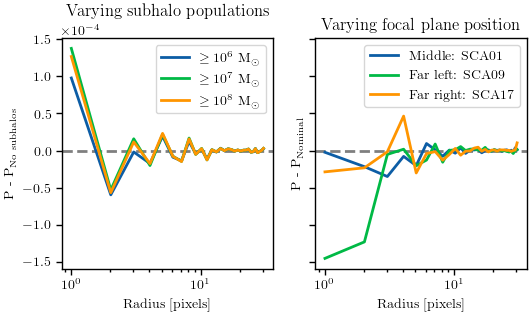

In [19]:
f, ax = plt.subplots(1, 3, figsize=(7, 3), sharey=True)

# ax.plot(r, flat_ps, label='flat')
# ax.plot(r, ps_no_subhalos, label='No subhalos')
ax[0].axhline(0, color='black', linestyle='--', alpha=0.5)
ax[0].plot(r, dif_6, label='$\geq 10^6$ M$_\odot$')
ax[0].plot(r, dif_7, label='$\geq 10^7$ M$_\odot$')
ax[0].plot(r, dif_8, label='$\geq 10^8$ M$_\odot$')
ax[0].set_xscale('log')
# ax.set_yscale('log')
ax[0].set_xlabel('Radius [pixels]')
ax[0].set_ylabel(r'P - P$_{\textrm{No subhalos}}$')
ax[0].legend()
ax[0].set_title('Varying subhalo populations')

ax[1].axhline(0, color='black', linestyle='--', alpha=0.5)
ax[1].plot(r, dif_1, label='Middle: SCA01')
ax[1].plot(r, dif_9, label='Far left: SCA09')
ax[1].plot(r, dif_17, label='Far right: SCA17')
ax[1].set_xscale('log')
# ax.set_yscale('log')
ax[1].set_xlabel('Radius [pixels]')
ax[1].set_ylabel(r'P - P$_{\textrm{Nominal}}$')
ax[1].legend()
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[1].set_title('Varying focal plane position')

plt.savefig(os.path.join(figure_dir, 'ps_one_system.png'))
plt.show()